# Coding your own RNN

Using this pre-filled notebook, we will code our own RNN for sentence classification. For now, we'll keep using IMDB, as the goal of this part is to understand how an RNN works.

Unlike our previous lab, we will also learn the embedding layer. Which means we need to deal with vocabulary by ourselves.

In [42]:
from functools import partial
from typing import Callable, Dict, Generator, List, Tuple

from datasets import load_dataset
import numpy as np
from sklearn.utils import shuffle
import torch
from torch import nn
from torchtext.vocab import vocab, Vocab
from torchtext.data.utils import get_tokenizer

from tqdm.auto import tqdm
import copy

import matplotlib.pyplot as plt

In [22]:
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

## Dataset
We load the dataset and split the training set in a stratified train/validation set.

In [23]:
dataset = load_dataset("imdb")
train_dataset = dataset["train"].train_test_split(
    stratify_by_column="label", test_size=0.2, seed=42
)
test_df = dataset["test"]
train_df = train_dataset["train"]
valid_df = train_dataset["test"]
train_df.shape, valid_df.shape, test_df.shape

  0%|          | 0/3 [00:00<?, ?it/s]

((20000, 2), (5000, 2), (25000, 2))

## Vocabulary (1 point)

**\[1 point\]** Build your own vocabulary. The [example provided in torchtext documentation](https://pytorch.org/text/stable/vocab.html#id1) might be of help.
* Don't forge to setup the `min_freq` parameter to not include unfrequent noise.
* You will need a tokenizer. Reuse the `basic_english` one from the our previous lab.
* For an RNN we need two special tokens: `<unk>`, for unknown words, and `<pad>` for padding.

In [24]:
from collections import Counter

tokenizer = get_tokenizer("basic_english")
unknown_token="<unk>"
pad_token="<pad>"

vocabulary = vocab(
    Counter([token for text in train_df["text"] for token in tokenizer(text)]),
    min_freq=5,
    specials=["<unk>", "<pad>"],
)

## Vectorize and batch the input (3 points)

As seen in class, our model should take one-hot encoded vectors corresponding to the each token vocabulary id. However, computing a vector x matrix multiplication for every input is unnecessarily costly. Multiplying a one-hot vector with a matrix is the equivalent of taking one row of the matrix. In pyTorch, we provide ids for each token which will be used as input to an `nn.Embedding` layer. The id is simply the row in the embedding matrix.

**\[1 point\]** Fill the `vectorize_text` function returning a 1D torch tensor of `torch.long` for each input text.

In [25]:
def vectorize_text(
    text: str, vocabulary: Vocab, tokenizer: Callable[[str], List[str]]
) -> torch.Tensor:
    """
    Generate a tensor of vocabluary IDs for a given text.
    Args:
        text: the input text.
        vocabulary: a Vocab objects.
        tokenizer: a text tokenizer.
    Returns:
        A tensor of IDs (torch.long).
    """
    return torch.tensor([vocabulary[token] if token in vocabulary else vocabulary["<unk>"] for token in tokenizer(text)], dtype=torch.long)

In [26]:
text_pipeline = partial(vectorize_text, vocabulary=vocabulary, tokenizer=tokenizer)

Check the function is working correctly, especially it should return the right special id for unknown words.

In [27]:
text_pipeline("Some text I am thinking about... ragafqfa")

tensor([  40, 5226,   11,  270,  660,    8,   27,   27,   27,    0])

In [28]:
X_train = [text_pipeline(text) for text in tqdm(train_df["text"])]
y_train = train_df["label"]
X_valid = [text_pipeline(text) for text in tqdm(valid_df["text"])]
y_valid = valid_df["label"]
X_test = [text_pipeline(text) for text in tqdm(test_df["text"])]
y_test = test_df["label"]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/25000 [00:00<?, ?it/s]

To speed up the training process, we turn the inputs into batches, as we did last time. For batches to work, every line must have the same lengths. Last time, it was implicit as only a vector (the average of all embeddings) was provided. This time, every line has the length of a different review.

To go around this problem, we use padding. So every line within a batch is padded to the length of its longest element.

* **\[1 point\]** Fill the data generator function.

In [29]:
def data_generator(
    X: List[torch.tensor], y: List[int], pad_id: int, batch_size: int = 32
) -> Generator[Tuple[torch.Tensor, torch.Tensor], None, None]:
    """
    Yield batches from given input data and labels.
    Args:
        X: a list of tensor (input features).
        y: the corresponding labels.
        batch_size: the size of every batch [32].
    Returns:
        A tuple of tensors (features, labels).
    """
    X, y = shuffle(X, y, random_state=SEED)
    for i in range(0, len(X), batch_size):
        X_batch, y_batch = X[i : i + batch_size], y[i : i + batch_size]

        # Padding
        for batch_idx in range(len(X_batch)):
            padding_size = (max([len(x) for x in X_batch]) - len(X_batch[batch_idx]), 0)
            X_batch[batch_idx] = nn.functional.pad(X_batch[batch_idx], padding_size, value=pad_id)
        
        yield torch.stack(X_batch), torch.tensor(y_batch, dtype=torch.float32)

* **\[1 point\]** On which side should you pad and why?

RNN are model that store information from previous input. The RNN mainly "remember" the end of the sample, so padding at the end of the sample will lead to the fact, that it won't learn anything. It's difficult to keep long term memory and cannot process long sentence as it will mainly focus on the end. For these reasons, we decided to pad on the left, so that the end isn't the padding.

In [30]:
train_gen = lambda: data_generator(X_train, y_train, vocabulary[pad_token])
valid_gen = lambda: data_generator(X_valid, y_valid, vocabulary[pad_token])
test_gen = lambda: data_generator(X_test, y_test, vocabulary[pad_token])

## Classifier (3 points)

**\[3 points\]** Code your own RNN. Fill the `RNN` class correctly. Remember an RNN has 3 matrices and an embedding layer (see course slide 61).
* The embedding layer turns a one-hot vectors into dense vectors.
* The first matrix (W) connects the embedding to the hidden layer.
  * `embedding_size -> hidden_size`
* The second matrix (U) connect the previous hidden layer to the current one.
  * `hidden_size -> hidden_size`
* These to vectors are added and go through an activation function (e.g. $h_t = tanh(Wx_i+Uh_{t-1})$).
* The last matrix (V) connects the hidden layer to the hidden layer to the output.
  * `hidden_size -> 1`
* Donc forget to add an `init_hidden` function which initialize the first hidden layer to 0.

In [31]:
class RNN(nn.Module):
    def __init__(self, vocabulary_size: int, embedding_size: int, hidden_size: int) -> None:
        super().__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocabulary_size, embedding_size)
        self.W = nn.Linear(embedding_size, hidden_size)
        self.U = nn.Linear(hidden_size, hidden_size)
        self.V = nn.Linear(hidden_size, 1)

    def forward(self, x: torch.Tensor, hidden: torch.Tensor) -> torch.Tensor:
        x = self.embedding(x)
        hidden = torch.tanh(self.W(x) + self.U(hidden))
        output = self.V(hidden)
        return output, hidden

    def init_hidden(self, batch_size: int) -> torch.Tensor:
        return torch.zeros(batch_size, self.hidden_size, requires_grad=False)

## Training (2 points)

Training is a bit different than usual. We will need to sequentially (but in "batch parallel") go through an input, keeping track of the hidden layer, and use the last output as prediction.

**\[2 point\]** Code the training loop.
* Note that for each batch, you need to loop through the whole input and use the output of the last token as input to your criterion.
* Keep the best model evaluated on the validation set.
* Plot the training and validation losses.
* Training will take some time (~30 min on a T4 GPU). Make sure your results appear in the notebook.

In [32]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

In [48]:
n_embedding = 32
n_hidden = 64
model = RNN(len(vocabulary.get_itos()), n_embedding, n_hidden).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)

In [49]:
EPOCHS = 10

train_losses = []
valid_losses = []
best_model = None
best_valid_loss = np.inf

for n_epoch in tqdm(range(EPOCHS)):
    model.train()
    train_loss = 0

    # Train the RNN on each batch
    for X_batch, y_batch in train_gen():
        hidden = model.init_hidden(X_batch.shape[0])
        X_batch, y_batch, hidden = X_batch.to(device), y_batch.to(device), hidden.to(device)

        for i in range(X_batch.size()[1]):
            output, hidden = model(X_batch[:, i], hidden)
        
        # Compute the loss
        loss = criterion(output.squeeze(), y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    train_losses.append(np.mean(loss.item()))

    model.eval() 
    # Compute loss validation for each batch
    for X_batch, y_batch in valid_gen():
        hidden = model.init_hidden(X_batch.shape[0])
        X_batch, y_batch, hidden = X_batch.to(device), y_batch.to(device), hidden.to(device)

        loss = 0
        for i in range(X_batch.size()[1]):
            output, hidden = model(X_batch[:, i], hidden)
        loss = criterion(output.squeeze(), y_batch)
            
    valid_losses.append(np.mean(loss.item()))

    if np.mean(loss.item()) < best_valid_loss:
        best_valid_loss = np.mean(loss.item())
        best_model = copy.deepcopy(model)
    
    print(f"Epoch {n_epoch + 1}/{EPOCHS} | Training loss: {train_losses[-1]} | Validation loss: {valid_losses[-1]}")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10 | Training loss: 0.657284140586853 | Validation loss: 0.6537504196166992
Epoch 2/10 | Training loss: 0.6770758032798767 | Validation loss: 0.6533492803573608
Epoch 3/10 | Training loss: 0.6592229604721069 | Validation loss: 0.6025879979133606
Epoch 4/10 | Training loss: 0.581795871257782 | Validation loss: 0.590269923210144
Epoch 5/10 | Training loss: 0.49386799335479736 | Validation loss: 0.46820375323295593
Epoch 6/10 | Training loss: 0.4898971915245056 | Validation loss: 0.5096935629844666
Epoch 7/10 | Training loss: 0.3739107847213745 | Validation loss: 0.3451026976108551
Epoch 8/10 | Training loss: 0.4082953929901123 | Validation loss: 0.4388048052787781
Epoch 9/10 | Training loss: 0.389580100774765 | Validation loss: 0.38301438093185425
Epoch 10/10 | Training loss: 0.341602087020874 | Validation loss: 0.43310752511024475


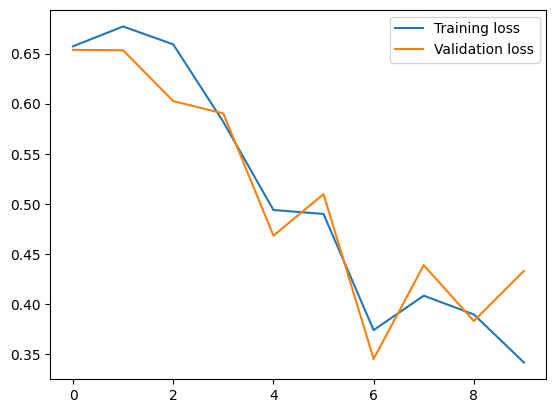

In [51]:
plt.plot(train_losses, label="Training loss")
plt.plot(valid_losses, label="Validation loss")
plt.legend();

## Evaluation (1 point)

* **\[1 point\]** Compute the accuracy for all 3 splits.

In [56]:
def accuracy(model: nn.Module, gen: Generator) -> float:
    """
    Compute the accuracy of a model on a given dataset.
    :param model: Model to evaluate.
    :param gen: generator function returning a batch (X, y).
    :return: the accuracy of the model on the given dataset.
    """
    model.eval()
    
    correct_sample = 0
    tot_sample = 0
    for X_batch, y_batch in gen():
        hidden = model.init_hidden(X_batch.shape[0])
        X_batch, y_batch, hidden = X_batch.to(device), y_batch.to(device), hidden.to(device)

        for i in range(X_batch.size()[1]):
            output, hidden = model(X_batch[:, i], hidden)
        
        # Sigmoid for binary classification.
        y_pred = torch.sigmoid(output.squeeze())
        y_pred = torch.round(y_pred)

        correct_sample += (y_pred == y_batch).sum().item()
        tot_sample += y_batch.size(0)

    return correct_sample / tot_sample

In [57]:
print(f"Accuracy : Train {accuracy(model, train_gen)} Valid {accuracy(model, valid_gen)} Test {accuracy(model, test_gen)}")

Accuracy : Train 0.84775 Valid 0.79 Test 0.78888
